In [1]:
import networkx as nx
import itertools
import pandas as pd
import numpy as np
from stellargraph import StellarGraph
from rdkit.Chem import AllChem, DataStructs

2023-06-14 14:10:31.401914: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-14 14:10:37.779892: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
g = nx.read_graphml("./graph/lotus_DB_as_graph.gml")
species_features_dummy = pd.read_csv("./data/species_features_dummy.csv", index_col=0)
molecule_features_dummy = pd.read_csv("./data/molecule_features_dummy.csv", index_col=0)
df_agg = pd.read_csv("./data/lotus_aggregated.csv", index_col=0)

In [3]:
G = StellarGraph.from_networkx(g,
                               node_features={'species':species_features_dummy,
                                              'molecule': molecule_features_dummy})
print(G.info())

StellarGraph: Undirected multigraph
 Nodes: 3448, Edges: 2179

 Node types:
  species: [1749]
    Features: float32 vector, length 1696
    Edge types: species-present_in->molecule
  molecule: [1699]
    Features: float32 vector, length 401
    Edge types: molecule-present_in->species, molecule-similar_to->molecule

 Edge types:
    molecule-present_in->species: [2000]
        Weights: range=[1, 30], mean=1.83, std=1.77304
        Features: none
    molecule-similar_to->molecule: [179]
        Weights: range=[0.8, 1], mean=0.926223, std=0.0809082
        Features: none


In [4]:
G.check_graph_for_ml()

In [5]:
import json
import pandas as pd
import numpy as np
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.metrics import mean_absolute_error, mean_squared_error

import stellargraph as sg
from stellargraph.mapper import HinSAGELinkGenerator
from stellargraph.layer import HinSAGE, link_regression, link_classification
from tensorflow.keras import Model, optimizers, losses, metrics

import multiprocessing
from stellargraph import datasets
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
batch_size = 200 #default: 200
epochs = 5
# Use 80% of edges for training, the rest for testing:
train_size = 0.8
test_size = 0.2

In [7]:
edges_with_ratings = df_agg[['structure_smiles_2D',
                             'organism_taxonomy_09species',
                            'reference_wikidata']]
edges_with_ratings['prob_presence'] = np.exp(-1/df_agg['reference_wikidata'])

/var/folders/_5/04k_n4g93v9bhbfk8nqpr3zr0000gs/T/ipykernel_2848/1907346342.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  edges_with_ratings['prob_presence'] = np.exp(-1/df_agg['reference_wikidata'])


In [8]:
edges_train, edges_test = model_selection.train_test_split(
    edges_with_ratings, train_size=train_size, test_size=test_size
)

edgelist_train = list(edges_train[["structure_smiles_2D", "organism_taxonomy_09species"]].itertuples(index=False))
edgelist_test = list(edges_test[["structure_smiles_2D", "organism_taxonomy_09species"]].itertuples(index=False))

labels_train = edges_train["prob_presence"]
labels_test = edges_test["prob_presence"]

In [9]:
num_samples = [8, 4]
generator = HinSAGELinkGenerator(
    G, batch_size, num_samples, head_node_types=["molecule", "species"]
)
train_gen = generator.flow(edgelist_train, labels_train, shuffle=True)
test_gen = generator.flow(edgelist_test, labels_test)


In [10]:
generator.schema.type_adjacency_list(generator.head_node_types, len(num_samples))

[('molecule', [2, 3]),
 ('species', [4]),
 ('species', [5]),
 ('molecule', [6, 7]),
 ('molecule', [8, 9]),
 ('molecule', []),
 ('species', []),
 ('molecule', []),
 ('species', []),
 ('molecule', [])]

In [11]:
generator.schema.schema

{'molecule': [EdgeType(n1='molecule', rel='present_in', n2='species'),
  EdgeType(n1='molecule', rel='similar_to', n2='molecule')],
 'species': [EdgeType(n1='species', rel='present_in', n2='molecule')]}

In [12]:
hinsage_layer_sizes = [32, 32]
assert len(hinsage_layer_sizes) == len(num_samples)

hinsage = HinSAGE(layer_sizes=hinsage_layer_sizes,
                  generator=generator,
                  bias=True,
                  dropout=0.0)

In [13]:
# Expose input and output sockets of hinsage:
x_inp, x_out = hinsage.in_out_tensors()

/usr/local/Caskroom/mambaforge/base/envs/stellar_graph/lib/python3.10/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [14]:
# Final estimator layer
score_prediction = link_classification(output_dim=1,
                                       output_act="relu",
                                       edge_embedding_method="ip")(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [17]:
import tensorflow.keras.backend as K
from tensorflow import keras

#def root_mean_square_error(s_true, s_pred):
#    return K.sqrt(K.mean(K.pow(s_true - s_pred, 2)))


model = Model(inputs=x_inp, outputs=score_prediction)
model.compile(optimizer=optimizers.Adam(learning_rate=1e-2),
              loss=keras.losses.binary_crossentropy,
              metrics=["acc"],
             )

In [18]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 8, 1696)]    0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 8, 401)]     0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 32, 401)]    0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 32, 1696)]   0           []                               
                                                                                            

                                                                                                  
 reshape_10 (Reshape)           (None, 1, 8, 32)     0           ['mean_hin_aggregator[2][0]']    
                                                                                                  
 dropout_15 (Dropout)           (None, 1, 32)        0           ['mean_hin_aggregator[0][0]']    
                                                                                                  
 dropout_13 (Dropout)           (None, 1, 8, 32)     0           ['reshape_8[0][0]']              
                                                                                                  
 dropout_14 (Dropout)           (None, 1, 8, 32)     0           ['reshape_9[0][0]']              
                                                                                                  
 dropout_17 (Dropout)           (None, 1, 32)        0           ['mean_hin_aggregator_1[0][0]']  
          

In [19]:
# Specify the number of workers to use for model training
import multiprocessing
num_workers = multiprocessing.cpu_count() - 2

In [20]:
test_metrics = model.evaluate(
    test_gen, verbose=1, use_multiprocessing=False, workers=num_workers
)

print("Untrained model's Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))

2/2 [==============================] - 2s 249ms/step - loss: 2.6380 - acc: 0.0000e+00
Untrained model's Test Evaluation:
	loss: 2.6380
	acc: 0.0000


In [21]:
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=epochs,
    verbose=1,
    shuffle=False,
    use_multiprocessing=False,
    workers=num_workers,
)

Epoch 1/5
8/8 [==============================] - 7s 495ms/step - loss: 0.9843 - acc: 0.0000e+00 - val_loss: 0.6983 - val_acc: 0.0000e+00
Epoch 2/5
8/8 [==============================] - 4s 421ms/step - loss: 0.6812 - acc: 0.0000e+00 - val_loss: 0.6952 - val_acc: 0.0000e+00
Epoch 3/5
8/8 [==============================] - 4s 432ms/step - loss: 0.6705 - acc: 0.0000e+00 - val_loss: 0.6943 - val_acc: 0.0000e+00
Epoch 4/5
8/8 [==============================] - 4s 449ms/step - loss: 0.6651 - acc: 0.0000e+00 - val_loss: 0.6950 - val_acc: 0.0000e+00
Epoch 5/5
8/8 [==============================] - 5s 566ms/step - loss: 0.6610 - acc: 0.0000e+00 - val_loss: 0.6955 - val_acc: 0.0000e+00


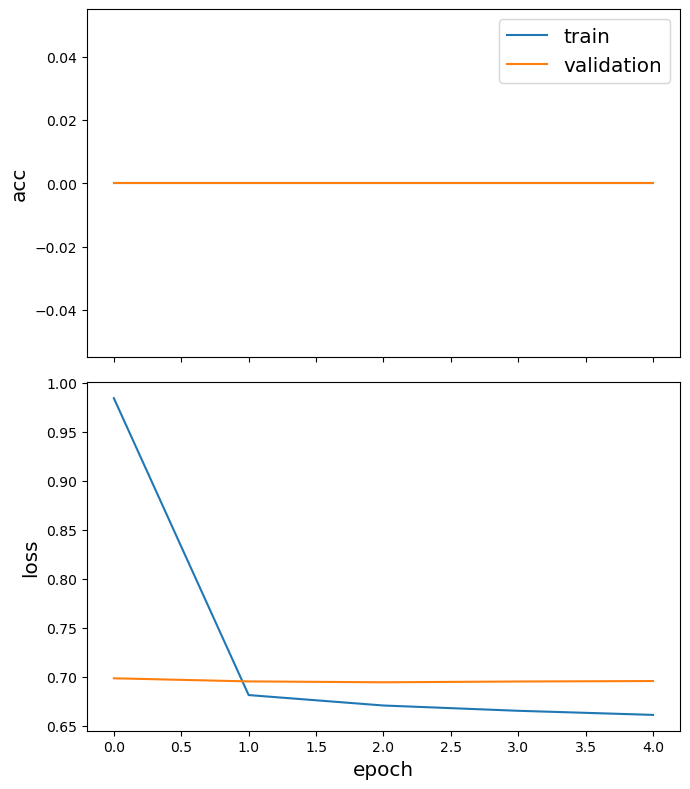

In [22]:
sg.utils.plot_history(history)

In [23]:
test_metrics = model.evaluate(
    test_gen, use_multiprocessing=False, workers=num_workers, verbose=1
)

print("Test Evaluation:")
for name, val in zip(model.metrics_names, test_metrics):
    print("\t{}: {:0.4f}".format(name, val))


2/2 [==============================] - 1s 345ms/step - loss: 0.6949 - acc: 0.0000e+00
Test Evaluation:
	loss: 0.6949
	acc: 0.0000


In [24]:
y_true = labels_test
# Predict the rankings using the model:
y_pred = model.predict(test_gen)
# Mean baseline rankings = mean movie ranking:
y_pred_baseline = np.full_like(y_pred, np.mean(y_true))

rmse = np.sqrt(mean_squared_error(y_true, y_pred_baseline))
mae = mean_absolute_error(y_true, y_pred_baseline)
print("Mean Baseline Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)
print("\nModel Test set metrics:")
print("\troot_mean_square_error = ", rmse)
print("\tmean_absolute_error = ", mae)

2/2 [==============================] - 1s 276ms/step
Mean Baseline Test set metrics:
	root_mean_square_error =  0.15956145785998824
	mean_absolute_error =  0.14332639582711212

Model Test set metrics:
	root_mean_square_error =  0.16278325001770497
	mean_absolute_error =  0.133289596771091


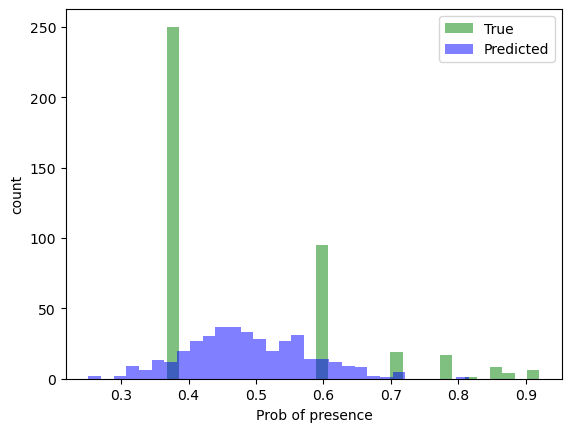

In [25]:
h_true = plt.hist(y_true, bins=30, facecolor="green", alpha=0.5)
h_pred = plt.hist(y_pred, bins=30, facecolor="blue", alpha=0.5)
plt.xlabel("Prob of presence")
plt.ylabel("count")
plt.legend(("True", "Predicted"))
plt.show()

In [26]:
test_gen_2 = generator.flow(edgelist_test, np.zeros(len(labels_test)))

In [27]:
mv = model.predict(test_gen_2)

2/2 [==============================] - 1s 270ms/step


In [28]:
mv

array([[0.36183727],
       [0.41263574],
       [0.35339242],
       [0.5697992 ],
       [0.5041411 ],
       [0.4478016 ],
       [0.32222447],
       [0.5465944 ],
       [0.47605574],
       [0.4078494 ],
       [0.38365185],
       [0.44415665],
       [0.48992413],
       [0.5906532 ],
       [0.8152261 ],
       [0.47290906],
       [0.49119008],
       [0.60208917],
       [0.49242675],
       [0.5574093 ],
       [0.46788466],
       [0.3641557 ],
       [0.66405004],
       [0.499816  ],
       [0.49841395],
       [0.56257445],
       [0.4564523 ],
       [0.5567851 ],
       [0.5077797 ],
       [0.63031316],
       [0.32928315],
       [0.41290134],
       [0.47110707],
       [0.5279045 ],
       [0.4987768 ],
       [0.5247172 ],
       [0.39211145],
       [0.48661798],
       [0.3994671 ],
       [0.56622124],
       [0.42944366],
       [0.57358855],
       [0.51437175],
       [0.5460628 ],
       [0.56893635],
       [0.5550047 ],
       [0.41867456],
       [0.558

In [29]:
#pd.DataFrame(edgelist_test)